# Dataset

## Loading Dataset

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch

# Caricamento del dataset
dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")

# Divisione del dataset
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

seed = 42
fraction = 0.25

# Usare solo il 25% del dataset di training
train_data = train_data.shuffle(seed=seed).select(range(int(len(train_data) * fraction)))

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(validation_data)}")
print(f"Test size: {len(test_data)}")


/home/enrico/Desktop/NLP-project/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 32332/32332 [00:00<00:00, 1173545.61 examples/s]


KeyError: 'validation'

## Preprocessing

In [ ]:

# Tokenizzatore
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Funzione di preprocessamento
def preprocess_data(example):
    max_input_length = 512
    max_output_length = 128

    # Tokenizzazione dell'articolo
    inputs = tokenizer(example['article'], max_length=max_input_length, truncation=True, padding="max_length", return_tensors="pt")
    # Tokenizzazione del sommario
    outputs = tokenizer(example['highlights'], max_length=max_output_length, truncation=True, padding="max_length", return_tensors="pt")
    
    return {
        "input_ids": inputs["input_ids"].squeeze(0),
        "attention_mask": inputs["attention_mask"].squeeze(0),
        "labels": outputs["input_ids"].squeeze(0)
    }

# Applicazione del preprocessamento
train_data = train_data.map(preprocess_data)
validation_data = validation_data.map(preprocess_data)


In [3]:
print(train_data)
print(train_data[0])

Dataset({
    features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 71778
})
{'article': "By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Saturday, with investigators saying the three died along with the family's pet dog, of carbon monoxide poisoning from a cooker. Tragic: The inquests have opened into the deaths of three members of the same family who were found in their static caravan last weekend. John and Audrey Cook are pictured . Awful: The family died following carbon monoxide poisoning at this 

# Model

## Structure

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Attenzione (Attention Mechanism)
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hid_dim)
        # encoder_outputs: (batch_size, seq_len, hid_dim)
        
        src_len = encoder_outputs.shape[1]
        
        # Ripetiamo lo stato nascosto per il batch_size
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, seq_len, hid_dim)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch_size, seq_len, hid_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, seq_len)
        
        # Normalizza l'attenzione
        attention = torch.softmax(attention, dim=1)  # (batch_size, seq_len)
        
        # Calcola il contesto pesato
        weighted = torch.bmm(attention.unsqueeze(1), encoder_outputs)  # (batch_size, 1, hid_dim)
        weighted = weighted.squeeze(1)  # (batch_size, hid_dim)
        
        return weighted, attention

# Encoder migliorato con attenzione
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs, hidden, cell

# Decoder con attenzione migliorato
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hid_dim)

    def forward(self, tgt, hidden, cell, encoder_outputs):
        embedded = self.dropout(self.embedding(tgt))
        
        # Applicazione dell'attenzione
        weighted, attention = self.attention(hidden[-1], encoder_outputs)  # hidden[-1] è lo stato nascosto finale
        
        # Ripetiamo il contesto 'weighted' per ogni elemento della sequenza del decoder
        weighted = weighted.unsqueeze(1).repeat(1, embedded.size(1), 1)  # (batch_size, seq_len, hid_dim)
        
        # Concatenazione tra embedded e weighted (attended context)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        
        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        predictions = self.fc_out(outputs)
        
        return predictions, hidden, cell, attention


# Modello Seq2Seq con attenzione
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_mask, tgt):
        encoder_outputs, hidden, cell = self.encoder(src, src_mask)
        outputs, hidden, cell, attention = self.decoder(tgt, hidden, cell, encoder_outputs)
        return outputs, attention


## Training

### Create DataLoader

In [5]:
from torch.utils.data import DataLoader

# Funzione per unire i dati in un batch
def collate_fn(batch):
    # Convertiamo le liste in tensori
    input_ids = torch.tensor([x['input_ids'] for x in batch])
    attention_mask = torch.tensor([x['attention_mask'] for x in batch])
    labels = torch.tensor([x['labels'] for x in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }


### Create Model

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch
torch.cuda.empty_cache()

import gc
gc.collect()

# Parametri del modello
INPUT_DIM = len(tokenizer)
OUTPUT_DIM = len(tokenizer)
EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")

# Inizializzazione del modello
encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)



Device: cuda


### Load Weights

In [56]:
# Carica i pesi salvati
model_to_load_name = "seq2seq.pt"
path = f"results/{model_to_load_name}"
model.load_state_dict(torch.load(f"{path}"))
model.eval()  # Imposta il modello in modalità inferenza

/tmp/ipykernel_10079/1473672977.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{path}"))


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30522, 256)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(30522, 256)
    (rnn): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=30522, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

### Training

In [7]:
# Ottimizzatore e funzione di perdita
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Funzione di training
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    
    for batch in tqdm(dataloader):
        src = batch['input_ids'].to(DEVICE)
        src_mask = batch['attention_mask'].to(DEVICE)
        tgt = batch['labels'].to(DEVICE)

        optimizer.zero_grad()
        
        # Calcolo dell'output del modello
        output, attention = model(src, src_mask, tgt)
        
        # Shift dei target per evitare <sos>
        output_dim = output.shape[-1]
        output = output[:, :-1, :].contiguous().view(-1, output_dim)
        tgt = tgt[:, 1:].contiguous().view(-1)
        
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)


# Creazione del DataLoader
#train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Usa un subset del dataset per velocizzare
train_data_small = train_data.select(range(2000))  # Limita il dataset a 1000 esempi
train_dataloader = DataLoader(train_data_small, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

train_losses = []

# Ciclo di addestramento
N_EPOCHS = 500
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    train_losses.append(train_loss)  # Aggiungi la loss alla lista
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}')


100%|██████████| 63/63 [00:11<00:00,  5.34it/s]


Epoch: 1, Training Loss: 7.8905


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 2, Training Loss: 7.3321


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 3, Training Loss: 7.2515


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 4, Training Loss: 7.1393


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 5, Training Loss: 7.0042


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 6, Training Loss: 6.8867


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 7, Training Loss: 6.7687


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 8, Training Loss: 6.6464


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 9, Training Loss: 6.5304


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 10, Training Loss: 6.4143


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 11, Training Loss: 6.2983


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 12, Training Loss: 6.1843


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 13, Training Loss: 6.0685


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 14, Training Loss: 5.9547


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 15, Training Loss: 5.8410


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 16, Training Loss: 5.7278


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 17, Training Loss: 5.6129


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 18, Training Loss: 5.5046


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 19, Training Loss: 5.3954


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 20, Training Loss: 5.2844


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 21, Training Loss: 5.1816


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 22, Training Loss: 5.0785


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 23, Training Loss: 4.9815


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 24, Training Loss: 4.8833


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 25, Training Loss: 4.7838


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 26, Training Loss: 4.6904


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 27, Training Loss: 4.6041


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 28, Training Loss: 4.5158


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 29, Training Loss: 4.4238


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 30, Training Loss: 4.3417


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 31, Training Loss: 4.2616


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 32, Training Loss: 4.1803


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 33, Training Loss: 4.1014


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 34, Training Loss: 4.0259


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 35, Training Loss: 3.9540


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 36, Training Loss: 3.8808


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 37, Training Loss: 3.8087


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 38, Training Loss: 3.7411


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 39, Training Loss: 3.6766


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 40, Training Loss: 3.6164


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 41, Training Loss: 3.5487


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 42, Training Loss: 3.4952


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 43, Training Loss: 3.4331


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 44, Training Loss: 3.3797


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 45, Training Loss: 3.3256


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 46, Training Loss: 3.2700


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 47, Training Loss: 3.2161


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 48, Training Loss: 3.1697


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 49, Training Loss: 3.1171


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 50, Training Loss: 3.0653


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 51, Training Loss: 3.0239


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 52, Training Loss: 2.9770


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 53, Training Loss: 2.9322


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 54, Training Loss: 2.8912


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 55, Training Loss: 2.8470


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 56, Training Loss: 2.8092


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 57, Training Loss: 2.7657


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 58, Training Loss: 2.7277


100%|██████████| 63/63 [00:11<00:00,  5.36it/s]


Epoch: 59, Training Loss: 2.6901


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 60, Training Loss: 2.6609


100%|██████████| 63/63 [00:11<00:00,  5.37it/s]


Epoch: 61, Training Loss: 2.6190


100%|██████████| 63/63 [00:11<00:00,  5.37it/s]


Epoch: 62, Training Loss: 2.5805


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 63, Training Loss: 2.5465


100%|██████████| 63/63 [00:11<00:00,  5.37it/s]


Epoch: 64, Training Loss: 2.5139


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 65, Training Loss: 2.4776


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 66, Training Loss: 2.4477


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 67, Training Loss: 2.4168


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 68, Training Loss: 2.3898


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 69, Training Loss: 2.3565


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 70, Training Loss: 2.3294


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 71, Training Loss: 2.2952


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 72, Training Loss: 2.2685


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 73, Training Loss: 2.2381


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 74, Training Loss: 2.2220


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 75, Training Loss: 2.1896


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 76, Training Loss: 2.1614


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 77, Training Loss: 2.1359


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 78, Training Loss: 2.1074


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 79, Training Loss: 2.0840


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 80, Training Loss: 2.0615


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 81, Training Loss: 2.0380


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 82, Training Loss: 2.0127


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 83, Training Loss: 1.9943


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 84, Training Loss: 1.9700


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 85, Training Loss: 1.9464


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 86, Training Loss: 1.9255


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 87, Training Loss: 1.9047


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 88, Training Loss: 1.8766


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 89, Training Loss: 1.8624


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 90, Training Loss: 1.8417


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 91, Training Loss: 1.8214


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 92, Training Loss: 1.7999


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 93, Training Loss: 1.7778


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 94, Training Loss: 1.7629


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 95, Training Loss: 1.7433


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 96, Training Loss: 1.7243


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 97, Training Loss: 1.7001


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 98, Training Loss: 1.6887


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 99, Training Loss: 1.6663


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 100, Training Loss: 1.6525


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 101, Training Loss: 1.6355


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 102, Training Loss: 1.6143


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 103, Training Loss: 1.6011


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 104, Training Loss: 1.5838


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 105, Training Loss: 1.5631


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 106, Training Loss: 1.5529


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 107, Training Loss: 1.5321


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 108, Training Loss: 1.5178


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 109, Training Loss: 1.5015


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 110, Training Loss: 1.4861


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 111, Training Loss: 1.4709


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 112, Training Loss: 1.4551


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 113, Training Loss: 1.4454


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 114, Training Loss: 1.4294


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 115, Training Loss: 1.4166


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Epoch: 116, Training Loss: 1.4014


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 117, Training Loss: 1.3894


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 118, Training Loss: 1.3730


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 119, Training Loss: 1.3609


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 120, Training Loss: 1.3424


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 121, Training Loss: 1.3313


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 122, Training Loss: 1.3206


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 123, Training Loss: 1.3057


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 124, Training Loss: 1.2935


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 125, Training Loss: 1.2819


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 126, Training Loss: 1.2659


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 127, Training Loss: 1.2530


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 128, Training Loss: 1.2428


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 129, Training Loss: 1.2337


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 130, Training Loss: 1.2212


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 131, Training Loss: 1.2088


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 132, Training Loss: 1.1954


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 133, Training Loss: 1.1879


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 134, Training Loss: 1.1758


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 135, Training Loss: 1.1596


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 136, Training Loss: 1.1496


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 137, Training Loss: 1.1356


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 138, Training Loss: 1.1255


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 139, Training Loss: 1.1196


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 140, Training Loss: 1.1060


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 141, Training Loss: 1.0948


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 142, Training Loss: 1.0827


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 143, Training Loss: 1.0746


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 144, Training Loss: 1.0640


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 145, Training Loss: 1.0596


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 146, Training Loss: 1.0468


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 147, Training Loss: 1.0456


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 148, Training Loss: 1.0315


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 149, Training Loss: 1.0199


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 150, Training Loss: 1.0099


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 151, Training Loss: 0.9985


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 152, Training Loss: 0.9928


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Epoch: 153, Training Loss: 0.9815


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Epoch: 154, Training Loss: 0.9709


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 155, Training Loss: 0.9576


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 156, Training Loss: 0.9541


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 157, Training Loss: 0.9436


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 158, Training Loss: 0.9354


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 159, Training Loss: 0.9244


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 160, Training Loss: 0.9922


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 161, Training Loss: 0.9183


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 162, Training Loss: 0.9089


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 163, Training Loss: 0.8985


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 164, Training Loss: 0.8859


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 165, Training Loss: 0.8792


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 166, Training Loss: 0.8728


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 167, Training Loss: 0.8604


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 168, Training Loss: 0.8542


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 169, Training Loss: 0.8487


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 170, Training Loss: 0.8356


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 171, Training Loss: 0.8297


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 172, Training Loss: 0.8206


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 173, Training Loss: 0.8141


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 174, Training Loss: 0.8073


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 175, Training Loss: 0.7952


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 176, Training Loss: 0.7905


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 177, Training Loss: 0.7903


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Epoch: 178, Training Loss: 0.7794


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Epoch: 179, Training Loss: 0.7711


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 180, Training Loss: 0.7664


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 181, Training Loss: 0.7559


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 182, Training Loss: 0.7499


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 183, Training Loss: 0.7416


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 184, Training Loss: 0.7332


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 185, Training Loss: 0.7294


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 186, Training Loss: 0.7236


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 187, Training Loss: 0.7169


100%|██████████| 63/63 [00:11<00:00,  5.51it/s]


Epoch: 188, Training Loss: 0.7092


100%|██████████| 63/63 [00:11<00:00,  5.51it/s]


Epoch: 189, Training Loss: 0.7037


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 190, Training Loss: 0.6984


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 191, Training Loss: 0.6944


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 192, Training Loss: 0.6843


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 193, Training Loss: 0.6796


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 194, Training Loss: 0.6706


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 195, Training Loss: 0.6664


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 196, Training Loss: 0.6587


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 197, Training Loss: 0.6566


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 198, Training Loss: 0.6459


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 199, Training Loss: 0.6438


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 200, Training Loss: 0.6348


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 201, Training Loss: 0.6305


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 202, Training Loss: 0.6272


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 203, Training Loss: 0.6191


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 204, Training Loss: 0.6152


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 205, Training Loss: 0.6023


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 206, Training Loss: 0.5970


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 207, Training Loss: 0.5979


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 208, Training Loss: 0.6003


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 209, Training Loss: 0.5976


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 210, Training Loss: 0.5846


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 211, Training Loss: 0.5771


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 212, Training Loss: 0.5739


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 213, Training Loss: 0.5685


100%|██████████| 63/63 [00:11<00:00,  5.51it/s]


Epoch: 214, Training Loss: 0.5593


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Epoch: 215, Training Loss: 0.5551


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 216, Training Loss: 0.5514


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 217, Training Loss: 0.5468


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 218, Training Loss: 0.5406


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 219, Training Loss: 0.5341


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 220, Training Loss: 0.5352


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 221, Training Loss: 0.5283


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 222, Training Loss: 0.5226


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 223, Training Loss: 0.5205


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 224, Training Loss: 0.5155


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Epoch: 225, Training Loss: 0.5086


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Epoch: 226, Training Loss: 0.5024


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 227, Training Loss: 0.4978


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 228, Training Loss: 0.4928


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 229, Training Loss: 0.4899


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 230, Training Loss: 0.4881


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 231, Training Loss: 0.4815


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 232, Training Loss: 0.4753


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 233, Training Loss: 0.4684


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 234, Training Loss: 0.4662


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 235, Training Loss: 0.4662


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 236, Training Loss: 0.4583


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 237, Training Loss: 0.4576


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 238, Training Loss: 0.4539


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 239, Training Loss: 0.4471


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 240, Training Loss: 0.4429


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 241, Training Loss: 0.4381


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 242, Training Loss: 0.4376


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 243, Training Loss: 0.4321


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 244, Training Loss: 0.4266


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 245, Training Loss: 0.4249


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 246, Training Loss: 0.4208


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 247, Training Loss: 0.4144


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 248, Training Loss: 0.4128


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 249, Training Loss: 0.4102


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 250, Training Loss: 0.4071


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 251, Training Loss: 0.4077


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 252, Training Loss: 0.4011


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 253, Training Loss: 0.3948


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 254, Training Loss: 0.3953


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 255, Training Loss: 0.3878


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 256, Training Loss: 0.3858


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 257, Training Loss: 0.3802


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 258, Training Loss: 0.3781


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 259, Training Loss: 0.3760


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 260, Training Loss: 0.3700


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 261, Training Loss: 0.3686


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 262, Training Loss: 0.3648


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 263, Training Loss: 0.3627


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Epoch: 264, Training Loss: 0.3575


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 265, Training Loss: 0.3557


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 266, Training Loss: 0.3554


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 267, Training Loss: 0.3542


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 268, Training Loss: 0.3500


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 269, Training Loss: 0.3431


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 270, Training Loss: 0.3429


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 271, Training Loss: 0.3379


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 272, Training Loss: 0.3360


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 273, Training Loss: 0.3340


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 274, Training Loss: 0.3297


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 275, Training Loss: 0.3253


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 276, Training Loss: 0.3233


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 277, Training Loss: 0.3238


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 278, Training Loss: 0.3201


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 279, Training Loss: 0.3171


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 280, Training Loss: 0.3116


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 281, Training Loss: 0.3092


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 282, Training Loss: 0.3082


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 283, Training Loss: 0.3064


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 284, Training Loss: 0.3020


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 285, Training Loss: 0.3018


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 286, Training Loss: 0.2992


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 287, Training Loss: 0.2936


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 288, Training Loss: 0.2936


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 289, Training Loss: 0.2887


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 290, Training Loss: 0.2871


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 291, Training Loss: 0.2871


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 292, Training Loss: 0.2825


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 293, Training Loss: 0.2830


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 294, Training Loss: 0.2760


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 295, Training Loss: 0.2737


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 296, Training Loss: 0.2716


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 297, Training Loss: 0.2694


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 298, Training Loss: 0.2701


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 299, Training Loss: 0.2662


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 300, Training Loss: 0.2684


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 301, Training Loss: 0.2618


100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Epoch: 302, Training Loss: 0.2595


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 303, Training Loss: 0.2581


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 304, Training Loss: 0.2520


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 305, Training Loss: 0.2528


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 306, Training Loss: 0.2502


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 307, Training Loss: 0.2455


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 308, Training Loss: 0.2462


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 309, Training Loss: 0.2463


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 310, Training Loss: 0.2437


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 311, Training Loss: 0.2432


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 312, Training Loss: 0.2420


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 313, Training Loss: 0.2381


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 314, Training Loss: 0.2350


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 315, Training Loss: 0.2322


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 316, Training Loss: 0.2286


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 317, Training Loss: 0.2317


100%|██████████| 63/63 [00:11<00:00,  5.36it/s]


Epoch: 318, Training Loss: 0.2277


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 319, Training Loss: 0.2291


100%|██████████| 63/63 [00:11<00:00,  5.61it/s]


Epoch: 320, Training Loss: 0.2235


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 321, Training Loss: 0.2207


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 322, Training Loss: 0.2194


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 323, Training Loss: 0.2151


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 324, Training Loss: 0.2168


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 325, Training Loss: 0.2151


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 326, Training Loss: 0.2154


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 327, Training Loss: 0.2108


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 328, Training Loss: 0.2087


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 329, Training Loss: 0.2048


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 330, Training Loss: 0.2041


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 331, Training Loss: 0.2060


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 332, Training Loss: 0.2054


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 333, Training Loss: 0.2028


100%|██████████| 63/63 [00:11<00:00,  5.36it/s]


Epoch: 334, Training Loss: 0.1980


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 335, Training Loss: 0.1974


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 336, Training Loss: 0.1997


100%|██████████| 63/63 [00:11<00:00,  5.33it/s]


Epoch: 337, Training Loss: 0.1951


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 338, Training Loss: 0.1973


100%|██████████| 63/63 [00:11<00:00,  5.35it/s]


Epoch: 339, Training Loss: 0.1910


100%|██████████| 63/63 [00:11<00:00,  5.35it/s]


Epoch: 340, Training Loss: 0.1918


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 341, Training Loss: 0.1885


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 342, Training Loss: 0.1901


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 343, Training Loss: 0.1839


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 344, Training Loss: 0.1861


100%|██████████| 63/63 [00:11<00:00,  5.35it/s]


Epoch: 345, Training Loss: 0.1835


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 346, Training Loss: 0.1846


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 347, Training Loss: 0.1804


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 348, Training Loss: 0.1828


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 349, Training Loss: 0.1793


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 350, Training Loss: 0.1755


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 351, Training Loss: 0.1747


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 352, Training Loss: 0.1738


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 353, Training Loss: 0.1720


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 354, Training Loss: 0.1710


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 355, Training Loss: 0.1696


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 356, Training Loss: 0.1688


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 357, Training Loss: 0.1684


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 358, Training Loss: 0.1673


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 359, Training Loss: 0.1633


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 360, Training Loss: 0.1637


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 361, Training Loss: 0.1629


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 362, Training Loss: 0.1627


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 363, Training Loss: 0.1631


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 364, Training Loss: 0.1648


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 365, Training Loss: 0.1603


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 366, Training Loss: 0.1604


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 367, Training Loss: 0.1560


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 368, Training Loss: 0.1563


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 369, Training Loss: 0.1555


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 370, Training Loss: 0.1527


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 371, Training Loss: 0.1523


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 372, Training Loss: 0.1488


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 373, Training Loss: 0.1503


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 374, Training Loss: 0.1474


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 375, Training Loss: 0.1450


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 376, Training Loss: 0.1466


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 377, Training Loss: 0.1467


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 378, Training Loss: 0.1464


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 379, Training Loss: 0.1440


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 380, Training Loss: 0.1436


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 381, Training Loss: 0.1421


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 382, Training Loss: 0.1446


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 383, Training Loss: 0.1433


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 384, Training Loss: 0.1423


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 385, Training Loss: 0.1409


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 386, Training Loss: 0.1382


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 387, Training Loss: 0.1370


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 388, Training Loss: 0.1367


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 389, Training Loss: 0.1363


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 390, Training Loss: 0.1345


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 391, Training Loss: 0.1373


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 392, Training Loss: 0.1357


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 393, Training Loss: 0.1308


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 394, Training Loss: 0.1294


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 395, Training Loss: 0.1296


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 396, Training Loss: 0.1301


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 397, Training Loss: 0.1292


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 398, Training Loss: 0.1285


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 399, Training Loss: 0.1266


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 400, Training Loss: 0.1266


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 401, Training Loss: 0.1243


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 402, Training Loss: 0.1258


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 403, Training Loss: 0.1259


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 404, Training Loss: 0.1243


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 405, Training Loss: 0.1220


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 406, Training Loss: 0.1226


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 407, Training Loss: 0.1236


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 408, Training Loss: 0.1212


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 409, Training Loss: 0.1223


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 410, Training Loss: 0.1203


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 411, Training Loss: 0.1207


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 412, Training Loss: 0.1178


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 413, Training Loss: 0.1157


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 414, Training Loss: 0.1161


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 415, Training Loss: 0.1184


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 416, Training Loss: 0.1160


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 417, Training Loss: 0.1168


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 418, Training Loss: 0.1121


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 419, Training Loss: 0.1111


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 420, Training Loss: 0.1106


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 421, Training Loss: 0.1150


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 422, Training Loss: 0.1143


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 423, Training Loss: 0.1134


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 424, Training Loss: 0.1107


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 425, Training Loss: 0.1109


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 426, Training Loss: 0.1089


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 427, Training Loss: 0.1069


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 428, Training Loss: 0.1060


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 429, Training Loss: 0.1077


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 430, Training Loss: 0.1062


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 431, Training Loss: 0.1066


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 432, Training Loss: 0.1047


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 433, Training Loss: 0.1032


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 434, Training Loss: 0.1045


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 435, Training Loss: 0.1046


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 436, Training Loss: 0.1048


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 437, Training Loss: 0.1086


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 438, Training Loss: 0.1045


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 439, Training Loss: 0.1044


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 440, Training Loss: 0.1012


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 441, Training Loss: 0.1016


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 442, Training Loss: 0.1018


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 443, Training Loss: 0.1002


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 444, Training Loss: 0.1014


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 445, Training Loss: 0.1016


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 446, Training Loss: 0.0989


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 447, Training Loss: 0.0999


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Epoch: 448, Training Loss: 0.0992


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 449, Training Loss: 0.0982


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 450, Training Loss: 0.0990


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 451, Training Loss: 0.0986


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 452, Training Loss: 0.0986


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 453, Training Loss: 0.0950


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 454, Training Loss: 0.0953


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 455, Training Loss: 0.0969


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 456, Training Loss: 0.0979


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 457, Training Loss: 0.0953


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 458, Training Loss: 0.0949


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 459, Training Loss: 0.0981


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 460, Training Loss: 0.0930


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 461, Training Loss: 0.0962


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 462, Training Loss: 0.0927


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 463, Training Loss: 0.0936


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 464, Training Loss: 0.0917


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 465, Training Loss: 0.0931


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 466, Training Loss: 0.0909


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 467, Training Loss: 0.0900


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 468, Training Loss: 0.0897


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 469, Training Loss: 0.0880


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 470, Training Loss: 0.0868


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 471, Training Loss: 0.0869


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 472, Training Loss: 0.0881


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 473, Training Loss: 0.0884


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Epoch: 474, Training Loss: 0.0882


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


Epoch: 475, Training Loss: 0.0866


100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch: 476, Training Loss: 0.0901


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 477, Training Loss: 0.0876


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 478, Training Loss: 0.0861


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 479, Training Loss: 0.0864


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 480, Training Loss: 0.0848


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 481, Training Loss: 0.0811


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 482, Training Loss: 0.0842


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 483, Training Loss: 0.0841


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 484, Training Loss: 0.0825


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 485, Training Loss: 0.0853


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 486, Training Loss: 0.0853


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 487, Training Loss: 0.0860


100%|██████████| 63/63 [00:11<00:00,  5.45it/s]


Epoch: 488, Training Loss: 0.0841


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]


Epoch: 489, Training Loss: 0.0824


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Epoch: 490, Training Loss: 0.0847


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 491, Training Loss: 0.0877


100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Epoch: 492, Training Loss: 0.0848


100%|██████████| 63/63 [00:11<00:00,  5.51it/s]


Epoch: 493, Training Loss: 0.0822


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 494, Training Loss: 0.0834


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 495, Training Loss: 0.0810


100%|██████████| 63/63 [00:11<00:00,  5.47it/s]


Epoch: 496, Training Loss: 0.0814


100%|██████████| 63/63 [00:11<00:00,  5.46it/s]


Epoch: 497, Training Loss: 0.0776


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Epoch: 498, Training Loss: 0.0763


100%|██████████| 63/63 [00:11<00:00,  5.41it/s]


Epoch: 499, Training Loss: 0.0785


100%|██████████| 63/63 [00:11<00:00,  5.44it/s]

Epoch: 500, Training Loss: 0.0809


Fine addestramento
Loss:  [7.890458046443879, 7.332066725170802, 7.251469195835174, 7.139317860679021, 7.00416324252174, 6.886666668785943, 6.768654081556532, 6.6464119638715475, 6.530429802243671, 6.41426436106364, 6.298281525808667, 6.184335890270415, 6.068497105250283, 5.954654610346234, 5.840973861633786, 5.727770487467448, 5.612886951083229, 5.504569727276999, 5.395399858081151, 5.284447556450253, 5.18160545258295, 5.078517323448544, 4.981490233587841, 4.88327830178397, 4.783783912658691, 4.690422890678285, 4.604076090313139, 4.515824605548192, 4.423841052585178, 4.341702688307989, 4.261579195658366, 4.18027226887052, 4.101356063570295, 4.0258663760291205, 3.9540220858558777, 3.8808099731566412, 3.8087035322946217, 3.7410788498227556, 3.676606810282147, 3.61642639220707, 3.5486951593368774, 3.495248722651648, 3.4331160235026528, 3.379723064483158, 3.325575593918089, 3.269975927140978, 3.2161048480442593, 3.1697315223633296, 3.1171395475902255, 3.0653375292581226, 3.023915994734991

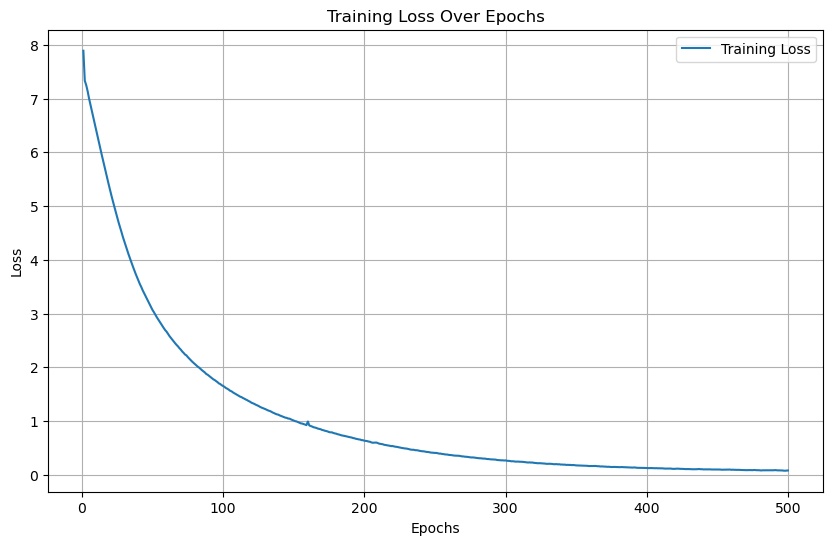

In [30]:
print("Fine addestramento")
print("Loss: ", train_losses)

# LOSS GRAPH
import matplotlib.pyplot as plt

# Plot della loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

### Save model

In [10]:
# Salvataggio del modello
model_name = "seq2seq-attention"
torch.save(model.state_dict(), f"./results/{model_name}.pt")


# Inference

In [31]:
import torch.nn.functional as F

def summarize(model, tokenizer, text):
    model.eval()
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(DEVICE)
    src, src_mask = tokens['input_ids'], tokens['attention_mask']
    
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src, src_mask)
        tgt = torch.LongTensor([tokenizer.cls_token_id]).unsqueeze(0).to(DEVICE)
        outputs = []
        for _ in range(256):  # Limite alla lunghezza del sommario
            prediction, hidden, cell, attention = model.decoder(tgt, hidden, cell, encoder_outputs)
            prob = F.softmax(prediction[0, -1, :], dim=0)
            #predicted_token = torch.multinomial(prob, 1).item()
            predicted_token = prediction.argmax(2)[:, -1].item()
            outputs.append(predicted_token)
            tgt = torch.cat([tgt, prediction.argmax(2)[:, -1].unsqueeze(0)], dim=1)
            if predicted_token == tokenizer.sep_token_id:
                break
    summary = tokenizer.decode(outputs, skip_special_tokens=True)
    return summary

# Test del modello
text = """Government aircraft – along with Russian planes based in Syria – have carried out bombing raids against opposition positions in Aleppo and Idlib provinces.

The official Russian news agency TASS cited the Syrian army command in a report Sunday as saying that their air forces “stepped up strikes on terrorist positions and their supply lines, with dozens killed and wounded.”

An airstrike close to Aleppo university on Sunday killed at least four people, according to social media video geolocated by CNN.

It is unclear whether the strike was carried out by Russian or Syrian regime planes. The strike follows one on Saturday which killed several people in a square in western Aleppo.

The White Helmets, a Syrian volunteer service, said at least four people were killed on Sunday in airstrikes on Idlib city, a province that now appears to be entirely in rebel hands.

In his first comments since the lightning takeover, Assad has said that Syria will continue “to defend its stability and territorial integrity in the face of all terrorists and their supporters,” during calls with regional leaders on Saturday.

Assad said Syria was capable “with the help of its allies and friends, of defeating and eliminating them, no matter how intense their terrorist attacks are.”

The rebel offensive has reignited Syria’s long-running civil war, which killed more than 300,000 people and created nearly 6 million refugees. The conflict never formally ended and the flare-up is the most significant since 2020, when Russia and Turkey reached a ceasefire in Idlib.

The rebels are led by Hayat Tahrir al-Sham (HTS), a former al Qaeda affiliate in Syria that used to go by the name Al-Nusra Front, along with groups backed by Turkey and others previously supported by the US.

This presents a dilemma for Western governments, Asli Aydintasbas, a Visiting Fellow at Brookings Institution, told CNN.

“Should they be cheering the opposition taking over Syria’s second-largest city Aleppo, or should they actually worry about the city falling under Islamist rule?” she said.

Aydintasbas believes the events that have unfolded in Syria show a new balance of power in the country, with Turkey emerging as a “major actor,” while Russia’s power is weakened and Iran is “on its back foot.”"""

print(summarize(model, tokenizer, text))


attorney says he will face a person - up she ' re make life.


In [25]:
results = []
for example in validation_dataloader:
    article = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
    summary = summarization_model(article, max_length=50, min_length=25, do_sample=False)
    results.append({"article": article, "summary": summary[0]["summary_text"]})

import json
with open("summaries.json", "w") as f:
    json.dump(results, f, indent=4)


TypeError: argument 'ids': 'list' object cannot be interpreted as an integer